In [99]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.metrics import rand_score, accuracy_score
import time

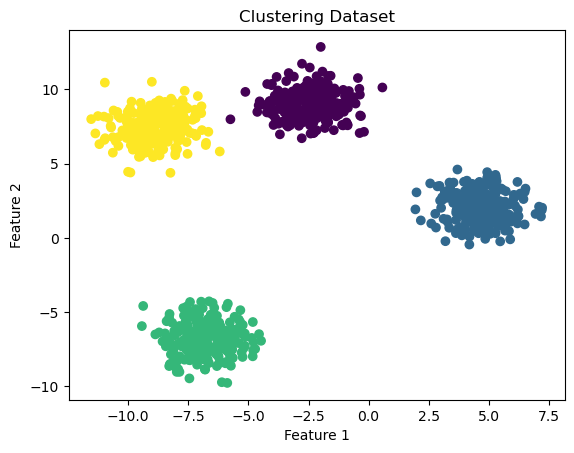

In [5]:
X, y = make_blobs(n_samples=1000, centers=4, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clustering Dataset')
plt.show()

In [6]:
frobenius_norm = np.linalg.norm(X, 'fro')
probabilities = np.sum(X**2, axis=1) / frobenius_norm**2

In [7]:
k = 20
chosen_rows = np.random.choice(np.arange(len(X)), size=k, replace=False, p=probabilities)
X_sample = X[chosen_rows]

In [108]:
def coreset(data, m):
    N = data.shape[0]
    
    mean = np.mean(data, axis=0)
    
    q = np.linalg.norm(data - mean, axis=1)**2
    sum = np.sum(q)
    q = 0.5 * (1.0/N + q/sum)
    
    samples = np.random.choice(N, m, p=q)
    coreset = data[samples]
    weights = 1.0 / (q[samples] * m)
    
    return coreset, weights, samples

In [69]:
from scipy.stats import mode

In [97]:
def kmeans(data, actual_labels, weights, k, max_iterations=15):
    data = np.asarray(data)
    
    mins = data.min(axis=0)
    maxs = data.max(axis=0)
    centroids = np.random.rand(k, data.shape[1]) * (maxs - mins) + mins
    
    for _ in range(max_iterations):
        dist = cdist(data, centroids)
        weighted_dist = dist * weights[:, np.newaxis]
        labels = np.argmin(weighted_dist, axis=1)
        
        for j in range(k):
            cluster = labels == j
            if weights[cluster].sum() > 0:
                centroids[j] = np.average(data[cluster], axis=0, weights=weights[cluster])
            else:
                centroids[j] = np.random.rand(1, data.shape[1]) * (maxs - mins) + mins

    labels = np.argmin(cdist(data, centroids, 'euclidean'), axis=1)
    label_map = {}
    for i in range(k):
        label_map[i] = mode(actual_labels[labels == i])[0]
    return centroids, label_map


def predict(data, centroids, label_map):
    dist = cdist(data, centroids)
    labels = np.argmin(dist, axis=1)
    return np.array([label_map[label] for label in labels])

In [127]:
def kmeansplusplus(data, actual_labels, weights, k, max_iterations=15):
    data = np.asarray(data)
    centroids = [data[np.random.choice(data.shape[0], replace=False)]]
    for i in range(1, k):
        dist = np.array(
            [np.min(cdist(x.reshape(1, -1), centroids, 'euclidean')) for x in data])
        dist = dist**2 
        dist = dist/np.sum(dist)  
        centroids.append(data[np.random.choice(data.shape[0], replace=False, p=dist)]) 
    centroids = np.array(centroids)
    for _ in range(max_iterations):
        dist = cdist(data, centroids)
        weighted_dist = dist * weights[:, np.newaxis]
        labels = np.argmin(weighted_dist, axis=1)
        
        for j in range(k):
            cluster = labels == j
            if weights[cluster].sum() > 0:
                centroids[j] = np.average(data[cluster], axis=0, weights=weights[cluster])
            else:
                centroids[j] = np.random.rand(1, data.shape[1]) * (maxs - mins) + mins

    labels = np.argmin(cdist(data, centroids, 'euclidean'), axis=1)
    label_map = {}
    for i in range(k):
        label_map[i] = mode(actual_labels[labels == i])[0]
    return centroids, label_map

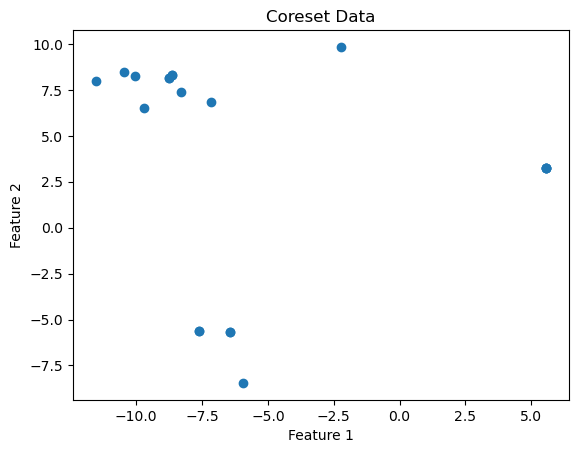

In [11]:
data_coreset, data_weights = coreset(X_sample, 20)
plt.scatter(data_coreset[:, 0], data_coreset[:, 1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Coreset Data')
plt.show()

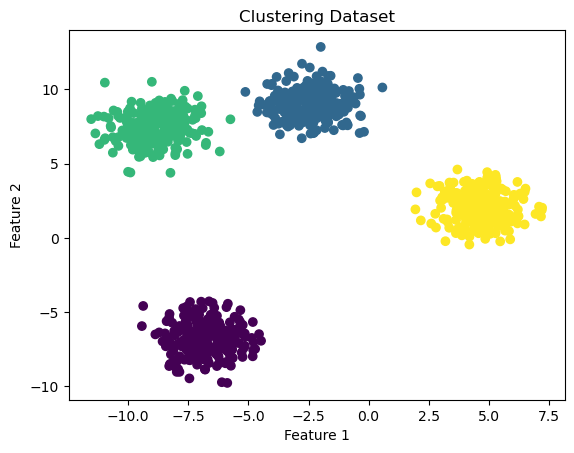

In [12]:
centroids_coreset = kmeans(data_coreset, data_weights, 4, 15)
labels_coreset = predict(X, centroids_coreset)

plt.scatter(X[:, 0], X[:, 1], c=labels_coreset)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clustering Dataset')
plt.show()

In [98]:
import torch
from torchvision import datasets, transforms
import numpy as np

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

X_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
Y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
Y_test = test_dataset.targets.numpy()

In [73]:
def sampling(X, k):
    N = X.shape[0]
    probabilities = np.sum(X**2, axis=1) / np.sum(X**2)
    samples = np.random.choice(N, k, p=probabilities)
    return X[samples], samples

In [113]:
def remove_top_k_pca_components(matrix, k):
    mean_vector = np.mean(matrix, axis=0)
    centered_matrix = matrix - mean_vector
    covariance_matrix = np.cov(centered_matrix, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_k_indices = sorted_indices[k:]
    remaining_eigenvectors = eigenvectors[:, top_k_indices]
    
    reconstructed_matrix = np.dot(centered_matrix, remaining_eigenvectors)
    reconstructed_matrix = np.dot(reconstructed_matrix, remaining_eigenvectors.T) + mean_vector
    return reconstructed_matrix

### Normal KMeans

In [106]:
tic = time.time()
image_centroids, label_map = kmeans(X_train, Y_train, np.ones(X_train.shape[0]), 10, 100)
image_labels = predict(X_test, image_centroids, label_map)
rand_index = rand_score(Y_test, image_labels)
print(f"Rand index: {rand_index}")
print(f"Accuracy: {accuracy_score(Y_test, image_labels)}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Rand index: 0.8589874187418742
Accuracy: 0.5097
Execution Time: 28.248323678970337


### FKV Sampling

In [117]:
tic = time.time()
X_sample, sample = sampling(X_train, 1000)
Y_sample = Y_train[sample]
image_centroids, label_map = kmeans(X_sample, Y_sample, np.ones(X_sample.shape[0]), 10, 10000)
image_labels = predict(X_test, image_centroids, label_map)
rand_index = rand_score(Y_test, image_labels)
print(f"Rand index: {rand_index}")
print(f"Accuracy: {accuracy_score(Y_test, image_labels)}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Rand index: 0.8185824382438244
Accuracy: 0.4788
Execution Time: 43.20739483833313


### Scalable KMeans

In [119]:
tic = time.time()
image_coreset, image_weights, samples = coreset(X_train, 1000)
image_coreset_centroids, image_labels = kmeans(image_coreset, Y_train[samples], image_weights, 10, 10000)
image_labels = predict(X_test, image_coreset_centroids, image_labels)
rand_index = rand_score(Y_test, image_labels)
print(f"Rand index: {rand_index}")
print(f"Accuracy: {accuracy_score(Y_test, image_labels)}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Rand index: 0.8731003300330032
Accuracy: 0.5764
Execution Time: 44.309935092926025


### Adaptive Sampling

In [121]:
tic = time.time()
reconstructed_matrix = remove_top_k_pca_components(X_train, 200)
X_sample, samples = sampling(reconstructed_matrix, 1000)
X_sample, Y_sample = X_train[samples], Y_train[samples]
image_coreset_centroids, image_labels = kmeans(X_sample, Y_sample, np.ones(X_sample.shape[0]), 10, 10000)
image_labels = predict(X_test, image_coreset_centroids, image_labels)
rand_index = rand_score(Y_test, image_labels)
print(f"Rand index: {rand_index}")
print(f"Accuracy: {accuracy_score(Y_test, image_labels)}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [126]:
image_centroids.shape

(10, 784)

In [128]:
tic = time.time()
image_centroids, label_map = kmeansplusplus(X_train, Y_train, np.ones(X_train.shape[0]), 10, 100)
image_labels = predict(X_test, image_centroids, label_map)
rand_index = rand_score(Y_test, image_labels)
print(f"Rand index: {rand_index}")
print(f"Accuracy: {accuracy_score(Y_test, image_labels)}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Rand index: 0.8784574457445744
Accuracy: 0.5944
Execution Time: 35.11557912826538


In [130]:
tic = time.time()
X_sample, sample = sampling(X_train, 1000)
Y_sample = Y_train[sample]
image_centroids, label_map = kmeansplusplus(X_sample, Y_sample, np.ones(X_sample.shape[0]), 10, 100)
image_labels = predict(X_test, image_centroids, label_map)
rand_index = rand_score(Y_test, image_labels)
print(f"Rand index: {rand_index}")
print(f"Accuracy: {accuracy_score(Y_test, image_labels)}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Rand index: 0.8639630363036304
Accuracy: 0.5512
Execution Time: 1.2760679721832275


In [131]:
tic = time.time()
image_coreset, image_weights, samples = coreset(X_train, 1000)
image_coreset_centroids, image_labels = kmeansplusplus(image_coreset, Y_train[samples], image_weights, 10, 100)
image_labels = predict(X_test, image_coreset_centroids, image_labels)
rand_index = rand_score(Y_test, image_labels)
print(f"Rand index: {rand_index}")
print(f"Accuracy: {accuracy_score(Y_test, image_labels)}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Rand index: 0.8731984398439844
Accuracy: 0.5327
Execution Time: 1.1906750202178955


In [134]:
tic = time.time()
reconstructed_matrix = remove_top_k_pca_components(X_train, 200)
X_sample, samples = sampling(reconstructed_matrix, 1000)
X_sample, Y_sample = X_train[samples], Y_train[samples]
image_coreset_centroids, image_labels = kmeansplusplus(X_sample, Y_sample, np.ones(X_sample.shape[0]), 10, 100)
image_labels = predict(X_test, image_coreset_centroids, image_labels)
rand_index = rand_score(Y_test, image_labels)
print(f"Rand index: {rand_index}")
print(f"Accuracy: {accuracy_score(Y_test, image_labels)}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [135]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

X_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
Y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
Y_test = test_dataset.targets.numpy()

100%|██████████| 26421880/26421880 [00:20<00:00, 1287238.40it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 618689.82it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1407714.23it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5818.43it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [136]:
tic = time.time()
image_centroids, label_map = kmeansplusplus(X_train, Y_train, np.ones(X_train.shape[0]), 10, 100)
image_labels = predict(X_test, image_centroids, label_map)
rand_index = rand_score(Y_test, image_labels)
print(f"Rand index: {rand_index}")
print(f"Accuracy: {accuracy_score(Y_test, image_labels)}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Rand index: 0.8774935893589358
Accuracy: 0.56
Execution Time: 36.99437999725342


In [137]:
tic = time.time()
X_sample, sample = sampling(X_train, 1000)
Y_sample = Y_train[sample]
image_centroids, label_map = kmeansplusplus(X_sample, Y_sample, np.ones(X_sample.shape[0]), 10, 100)
image_labels = predict(X_test, image_centroids, label_map)
rand_index = rand_score(Y_test, image_labels)
print(f"Rand index: {rand_index}")
print(f"Accuracy: {accuracy_score(Y_test, image_labels)}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Rand index: 0.8668401240124013
Accuracy: 0.5154
Execution Time: 1.200840950012207


In [138]:
tic = time.time()
image_coreset, image_weights, samples = coreset(X_train, 1000)
image_coreset_centroids, image_labels = kmeansplusplus(image_coreset, Y_train[samples], image_weights, 10, 100)
image_labels = predict(X_test, image_coreset_centroids, image_labels)
rand_index = rand_score(Y_test, image_labels)
print(f"Rand index: {rand_index}")
print(f"Accuracy: {accuracy_score(Y_test, image_labels)}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Rand index: 0.8472403440344034
Accuracy: 0.5434
Execution Time: 1.0056231021881104


In [139]:
tic = time.time()
reconstructed_matrix = remove_top_k_pca_components(X_train, 200)
X_sample, samples = sampling(reconstructed_matrix, 1000)
X_sample, Y_sample = X_train[samples], Y_train[samples]
image_coreset_centroids, image_labels = kmeansplusplus(X_sample, Y_sample, np.ones(X_sample.shape[0]), 10, 100)
image_labels = predict(X_test, image_coreset_centroids, image_labels)
rand_index = rand_score(Y_test, image_labels)
print(f"Rand index: {rand_index}")
print(f"Accuracy: {accuracy_score(Y_test, image_labels)}")
toc = time.time()

print(f"Execution Time: {toc -tic}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
